# Automatic feature selection with LASSO regression

In this notebook we will learn how LASSO (Least Absolute Shrinkage and Selection Operator) regression works and how it can assist in automatically selecting which variables should be included using a **Cross-Validation** perspective.

### Start by importing packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_diabetes
from sklearn.feature_selection import SelectFromModel
from sklearn import datasets, linear_model
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels
from statsmodels.api import OLS

#### Load dataset and inspect it

-   Again we're going to use our diabetes dataset.
    -   Inspect it again just to remind yourself what is in it.

In [ ]:
# Load the diabetes dataset
diabetes = load_diabetes()

# Extract numpy arrays for X and y
X = diabetes.data
y = diabetes.target

# Get the feature names
feature_names = diabetes.feature_names

# Print them out to look at them
print(diabetes['DESCR'])
print(feature_names)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

### Select subset of data

-   To speed up calculation, we're going to just use the first 150 observations
    -   Use numpy slice notation to grab them out of the X, y

In [ ]:
# Remember the notation for slices: X[start:stop:step]
# where omitted values default to start=0, stop=size of dimension, step=1
# So, X[:150] means "grab the first 150 rows"
# X = X[:]
# y = y[:150]

# Split the data into training/testing sets using scikit-learn's train_test_split() function
from sklearn.model_selection import train_test_split

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Run OLS first (for comparison)

Remember the standard Sklearn model steps:

1.  create the model object
2.  call the object's fit method.
3.  use the fitted model to predict something.
4.  assess the predictions.

In [ ]:
# Create linear regression object
model_ols = linear_model.LinearRegression()

# Train the model using the training sets
model_ols.fit(X_train, y_train)

# Make predictions using the testing set
y_train_hat = model_ols.predict(X_train)

# The coefficients
print("Coefficients: \n", model_ols.coef_)

# The mean squared error
mse_ols = mean_squared_error(y_train, y_train_hat)
print("Mean squared error:", mse_ols)

# The coefficient of determination: 1 is perfect prediction
r2_train_ols = r2_score(y_train, y_train_hat)
print("Coefficient of determination:", r2_train_ols)

Coefficients: 
 [  32.14928032 -242.82449076  559.98996952  407.63766881 -718.69857577
  396.63703933   10.432395    171.81955335  627.07993787  -21.62312454]
Mean squared error: 2949.291573722149
Coefficient of determination: 0.5097545616479949


### Do it again in the econometrics style

-   Recall that the package statsmodels is closer to the econometrician's way of doing things.
-   We're going to quickly repeat the steps above but with Statsmodels so we can view it in a nice table form.

In [ ]:
x_train_with_constant = statsmodels.api.add_constant(X_train)
result = OLS(y_train, x_train_with_constant).fit().summary()

print(result)

# Notice that the R-squared is the same as above

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     29.63
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           9.78e-39
Time:                        12:29:36   Log-Likelihood:                -1602.4
No. Observations:                 296   AIC:                             3227.
Df Residuals:                     285   BIC:                             3267.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        150.4340      3.223     46.679      0.0

### Plot y and y_hat

-   Let's also plot y and y_hat compared to one of the most important variables, BMI.
    -   We'll see both y and y_hat resemble each other.

Text(0.5, 0, 'BMI')

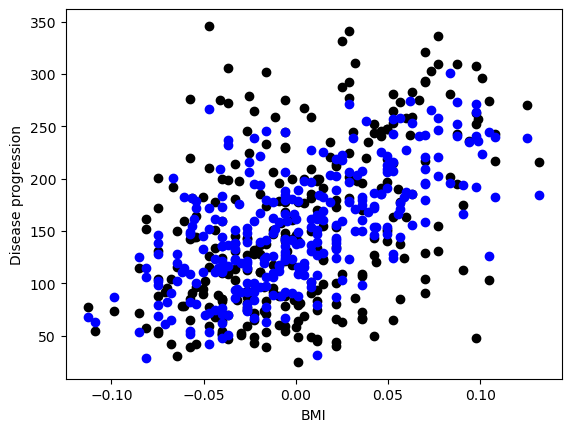

In [ ]:
# Plot outputs (comparing 1 variable (BMI in column 3) to y and y_hat
# plt.scatter() takes 2 numpy arrays.
# The X[:, 3] notation gets all rows but only in column at index 3 (BMI)
# And recall that y is "a quantitative measure of disease progression one year after baseline"

# Plot the actual y values in black
plt.scatter(X_train[:, 3], y_train, color="black")

# Plot the predicted y values in blue
plt.scatter(X_train[:, 3], y_train_hat, color="blue")

# Add vertical axis label
plt.ylabel('Disease progression')

# Add horizontal axis label
plt.xlabel('BMI')

# DISCUSSION QUESTION: Why is BMI centered on 0? Isn't it like a value of 20-30?

## Switch to LASSO

Now that we've spent all this time setting up our python environment and getting sklearn, it's almost a trivial step in many cases to try out the latest-and-greatest model.

### Create a LASSO model object

-   Today's goal, however, is to do Lasso on this same dataset.
    -   To start, lets create a Lasso object.
    -   Notice that we are not setting the alpha/gamma value when we create it.
-   STEP 1: Create the object

In [ ]:
# Create an empty Lasso object with a few initial parameters set
model_lasso = Lasso(alpha=1.0, random_state=42, max_iter=10000) # Note, alpha is set by default to 1.0 so we could have omitted it here (though I kept it in to make it clear)
print(model_lasso)

Lasso(max_iter=10000, random_state=42)


### Fit the LASSO

-   STEP 2: Call the lasso.fit() method.
    -   The key think is to understand which X and y you are working with
    -   We haven't split into training and testing YET, so it doesn't matter here

In [ ]:
y_train_hat_lasso = model_lasso.fit(X_train, y_train)
print(model_lasso, ': I might look the same but now i\'m FIT!')

Lasso(max_iter=10000, random_state=42) : I might look the same but now i'm FIT!


### Predict with the LASSO

-   STEP 3: Predict
    -   Save the results to a new variable called y_hat_lasso
        -   We will use this later

In [ ]:
y_train_hat_lasso = model_lasso.predict(X_train)
print('y_hat_lasso', y_train_hat_lasso)

y_hat_lasso [140.96682887 184.45963875 151.38141417 142.5060501  164.0766917
 207.2411456  152.18258246 160.22710171 124.21229452 158.28966912
 149.12496793 133.08787638 134.21736573 156.5611931  143.21811498
 109.39498512 115.64275168 135.60151808 141.04716136 155.6476225
 170.50804739 110.77877038 127.91886973 137.93946488 148.79523371
 105.53749247 130.21546335 174.1131896  190.63846919 174.2309839
 186.64023467 192.93272357 193.5094217  147.69586048 146.89933608
 156.18872817 151.45629843 118.59895035 153.52475919 134.48818838
 112.78168684 179.26426367 173.6608597  166.2237288  104.65911294
 167.89405249 167.39220787 138.30802365 200.83677708 122.12207822
 196.8943563  163.25693129 168.3352627  159.04692729 138.12124162
 173.13128655 187.81680817 128.42575585 124.67879868 140.38415367
 182.96445145 111.4892178  193.85342288 170.02534386 161.90953412
 148.21584477 121.81930993 133.73868374 168.46985105 147.88932685
 169.44584389 145.43306108 120.4248471  144.61233498 141.52098391
 

### Plot it too to compare it with the OLS plot from above

What do you see. Is this expected?

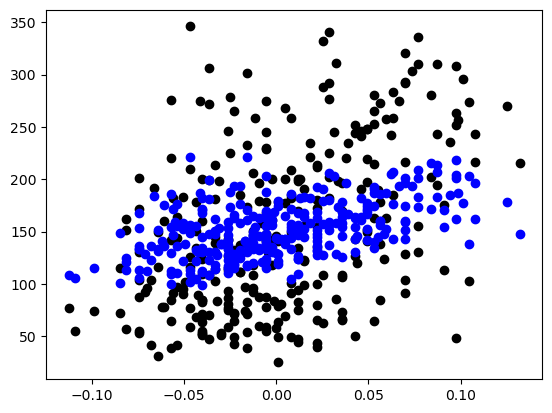

In [ ]:
# Plot outputs
plt.scatter(X_train[:, 3], y_train, color="black")
plt.scatter(X_train[:, 3], y_train_hat_lasso, color="blue")

plt.show()

### Compare the actual coefficients created

Class question: How are they different? And how are they similar?

In [ ]:
print(model_lasso.coef_)
print(model_ols.coef_)

[  0.          -0.         425.89571524  69.18564617   0.
   0.          -0.           0.         177.77602164   0.        ]
[  32.14928032 -242.82449076  559.98996952  407.63766881 -718.69857577
  396.63703933   10.432395    171.81955335  627.07993787  -21.62312454]


## Exercise 1

Use a loop to identify the best value of alpha, as measured by r-squared.

Write all of the alphas and associated r2 into a dictionary

Discussion question for once you're done: what was the optimal alpha and why does this make sense? How does this compare to OLS? Why is it that way?

In [ ]:
# Exercise 1 Code
scores = {}
alphas = np.logspace(-5, -0.05, 30)
for alpha in alphas:
    model_lasso = Lasso(alpha=alpha, random_state=0, max_iter=10000)
    model_lasso.fit(X_train, y_train)
    y_train_hat_lasso = model_lasso.predict(X_train)
    r2 = r2_score(y_train, y_train_hat_lasso)
    ### FILL IN HERE
    scores[alpha] = r2
    print('Alpha', alpha, 'r2', r2) 
    

# Quick way to get the value from the highest-valued dictionary entry
best_alpha = max(scores, key=scores.get)

# print best_alpha with all the significant digits
print('best_alpha', best_alpha)

# This is not very pretty. There MUST be a better way to do this.
# There is!

Alpha 1e-05 r2 0.5097545586312984
Alpha 1.4814590630121231e-05 r2 0.5097545550258286
Alpha 2.194720955380762e-05 r2 0.5097545471156377
Alpha 3.251389250131456e-05 r2 0.5097545297584842
Alpha 4.816800071987436e-05 r2 0.5097544916576326
Alpha 7.135892121363248e-05 r2 0.5097544080163654
Alpha 0.00010571532055870389 r2 0.5097542245101425
Alpha 0.0001566129197409237 r2 0.5097538216693466
Alpha 0.00023201562933498188 r2 0.5097529376097034
Alpha 0.00034372165683877067 r2 0.5097509978881833
Alpha 0.0005092095636773398 r2 0.5097502179536177
Alpha 0.0007543731230822445 r2 0.5097465191497694
Alpha 0.001117572900082952 r2 0.5097369145233267
Alpha 0.0016556385014046312 r2 0.5097158518651634
Alpha 0.002452760662977703 r2 0.509669630836878
Alpha 0.003633664513567942 r2 0.5095683199329282
Alpha 0.005383125225570771 r2 0.5093462639791546
Alpha 0.007974879652751007 r2 0.5088596929799117
Alpha 0.01181445773799895 r2 0.5077994072091762
Alpha 0.01750263549053227 r2 0.507560279935038
Alpha 0.025929437974046

## Operationalizing CV with GridSearch

-   It seems a little weird to be automatically finding the best model.

    -   If we were just applying this to the dataset a single time, this would indeed be p-hacking to the extreme.

    -   However, showing its performance on UNSEEN data is quite the opposite of p-hacking.

-   Scikit Learn lets us operationalize our method for finding the best model by using GridSearch.

-   GridSEarch will search for the best set of "hyperparameters" we can find.

    -   Here we only have 1 hyperparameter, alpha.

        -   Our plan will be to split the training data into 5 folds, and then test each alpha on each fold, keeping track of which alpha performed best.

            -   Why split into folds instead of just testing each alpha on one split of the training data?

                -   We can eek-out much more training power by reusing the data lots of times in different splits.

![](images/paste-1.png)

### Setup the inputs for GridSearchCV

-   Define a range of alphas we will test using numpy logspace:

In [ ]:
alphas = np.logspace(-6, -0.5, 30)
print(alphas)

[1.00000000e-06 1.54758735e-06 2.39502662e-06 3.70651291e-06
 5.73615251e-06 8.87719709e-06 1.37382380e-05 2.12611233e-05
 3.29034456e-05 5.09209564e-05 7.88046282e-05 1.21957046e-04
 1.88739182e-04 2.92090372e-04 4.52035366e-04 6.99564216e-04
 1.08263673e-03 1.67547492e-03 2.59294380e-03 4.01280703e-03
 6.21016942e-03 9.61077966e-03 1.48735211e-02 2.30180731e-02
 3.56224789e-02 5.51288979e-02 8.53167852e-02 1.32035178e-01
 2.04335972e-01 3.16227766e-01]


-   We are going to be passing this range of tuning parameters to a GridSearch

    -   It .fit() function will test which alpha works best across all of the folds.

-   First though, we have to put the alphas into the form the GridSearchCV function Expects, which is a list of dictionaries.

    -   More complex models might have lots of different hyperparameters.

In [ ]:
tuning_parameters = [{'alpha': alphas}]

### Choose how many folds to use

-   Recall that CV works by calculating the fit quality of different folds of the training data.

    -   Here we will just use 5 folds. GridSearchCV will automatically implement the folding and testing logic.

In [ ]:
n_folds = 5

#### Create the lasso_cv object from the lasso object

-   Finally, we have all our objects ready to pass to the GridSearchVC function

    -   Create a new GridSearchCV object.

        -   Notice that we are reusing model_lasso object we created above.

In [ ]:
model_lasso_cv = GridSearchCV(model_lasso, tuning_parameters, cv=n_folds, refit=False)

#### Fit the lasso_cv object

When we call the model_lasso_cv.fit() method, we will iteratively be calling the Lasso.fit() with different permutations of tuned parameters and then will return the classifier with the best CV fit.

In [ ]:
model_lasso_cv.fit(X_train, y_train)

,estimator,Lasso(alpha=n...andom_state=0)
,param_grid,[{'alpha': array([1.0000...16227766e-01])}]
,scoring,None
,n_jobs,None
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,np.float64(0.8912509381337456)


-   Although it was just one line, we just ran a BOATLOAD of Lasso regressions.

-   The `model_lasso_cv` object now has a variety of diagnostic metrics, reporting back on different folds within the Cross Validation. Take a look at them below.

In [ ]:
print('model_lasso_cv keys returned:', model_lasso_cv.cv_results_.keys())

model_lasso_cv keys returned: dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


### Extract results by score

Some relevant results are as below, which we'll extract and assign to lists.

In [ ]:
scores = model_lasso_cv.cv_results_['mean_test_score']
scores_std = model_lasso_cv.cv_results_['std_test_score']

print('scores', scores)
print('scores_std', scores_std)

scores [0.4519634  0.45196352 0.45196371 0.451964   0.45196446 0.45196515
 0.45196624 0.45196791 0.45197048 0.45197446 0.45198058 0.45198996
 0.45200427 0.45202593 0.45205828 0.45210554 0.45217195 0.45225864
 0.4523543  0.45225214 0.45186538 0.45133124 0.45135412 0.45225194
 0.45327032 0.45417588 0.45341964 0.45034518 0.44410909 0.43147344]
scores_std [0.11327806 0.11327787 0.11327757 0.1132771  0.11327638 0.11327526
 0.11327353 0.11327085 0.11326671 0.11326031 0.11325042 0.11323514
 0.11321157 0.11317528 0.11311953 0.11303428 0.11290482 0.11271031
 0.11242329 0.11203524 0.11146881 0.11078125 0.11065965 0.11042615
 0.11011996 0.10929459 0.10846076 0.10624549 0.1041817  0.09781666]


## Exercise 2:

With your table, explore the scores and alphas lists we've created. Identify which alpha is the best, based on the MSE score returned. A challenge here is that sklearn gave us the scores as a list rather than a dictionary (as we built above), so you will need to use the list to create the dictionary.

One way to consider doing this would be to create a for loop to iterate through a range(len(scores)): object, saving the alphas and scores to a new dictionary, as in the starter code below.

Save the optimal alpha as a new variable called chosen_alpha.

In [ ]:
# Exercise 2 Code

output_dict = {}
for i in range(len(scores)):
    output_dict[alphas[i]] = scores[i]
    
best_alpha = max(output_dict, key=output_dict.get)

print('best_alpha', best_alpha)

best_alpha 0.055128897887706724


### Plot out the alphas and their scores

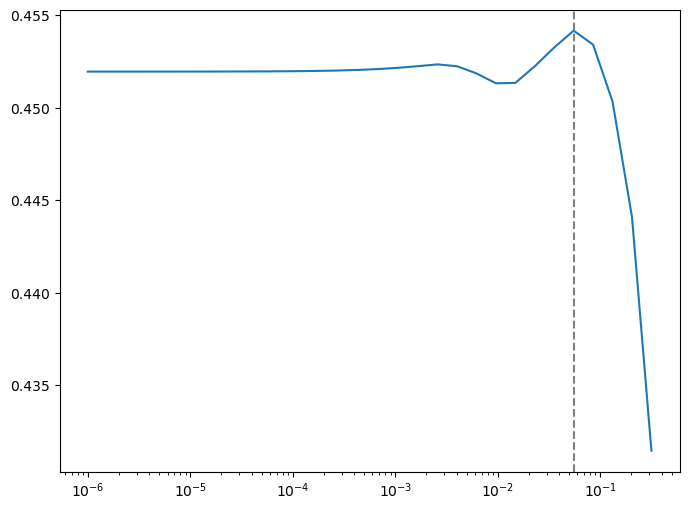

In [ ]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)
# Also add an annotation vertical dotted line indicating the optimal alpha
plt.axvline(best_alpha, linestyle='--', color='.5')

### Use the built-in attributes to get the best alpha

-   Fortunately, the authors provide a useful best_params\_ attribute.

In [ ]:
print('best_parameters:', model_lasso_cv.best_params_)

best_parameters: {'alpha': np.float64(0.055128897887706724)}


-   Extract the best alpha, which we will use later.

In [ ]:
chosen_alpha = model_lasso_cv.best_params_['alpha']
print('chosen_alpha', chosen_alpha)

chosen_alpha 0.055128897887706724


### Rerun LASSO with the best alpha

-   Now we can rerun a vanilla (no CV) version of Lasso with that specific alpha.

    -   This will return, for instance, a `model_lasso_cv_2.coef_` list.

In [ ]:
model_lasso_cv_2 = Lasso(alpha=chosen_alpha, random_state=0, max_iter=10000).fit(X_train, y_train)

print("coefficients", model_lasso_cv_2.coef_)

coefficients [   3.32833354 -190.6812396   565.88225618  376.65614325 -115.53479856
   -0.         -258.7395582     0.          409.99906108    0.        ]


-   Simply looking at the coefficients tells us which are to be included. Question: How will we know just by looking?

### Extract the feature names and column indices of the features that Lasso has selected.

In [ ]:
selected_coefficient_labels = []
selected_coefficient_indices = []
for i in range(len(model_lasso_cv_2.coef_)):
    print('Coefficient', feature_names[i], 'was', model_lasso_cv_2.coef_[i])
    if abs(model_lasso_cv_2.coef_[i]) > 0:
        selected_coefficient_labels.append(feature_names[i])
        selected_coefficient_indices.append(i)

Coefficient age was 3.3283335444260103
Coefficient sex was -190.68123960346233
Coefficient bmi was 565.8822561762518
Coefficient bp was 376.65614325147214
Coefficient s1 was -115.53479856353225
Coefficient s2 was -0.0
Coefficient s3 was -258.739558196292
Coefficient s4 was 0.0
Coefficient s5 was 409.9990610793234
Coefficient s6 was 0.0


This process led us to the following selected_coefficient_labels:

In [ ]:
print('selected_coefficient_labels', selected_coefficient_labels)

selected_coefficient_labels ['age', 'sex', 'bmi', 'bp', 's1', 's3', 's5']


## Switch back to slides

## Post-LASSO

Finally, now that we have our selected labels, we can use them to select the numpy array columns that we want to use for a post-LASSO run.

In [ ]:
X_train_selected = X_train[:, selected_coefficient_indices]
print('X_train_selected', X_train_selected)

X_train_selected [[ 0.0090156  -0.04464164 -0.03099563 ...  0.00806271  0.00446045
   0.00943366]
 [-0.00188202 -0.04464164  0.05415152 ...  0.07273249 -0.04340085
   0.08449153]
 [ 0.0090156   0.05068012 -0.00512814 ...  0.06998059 -0.03971921
   0.03954249]
 ...
 [ 0.03081083 -0.04464164 -0.02021751 ... -0.00432087  0.0780932
  -0.01090325]
 [-0.01277963 -0.04464164 -0.02345095 ... -0.01670444 -0.01762938
  -0.03845972]
 [-0.09269548 -0.04464164  0.02828403 ...  0.03695772  0.05600338
  -0.00514219]]


Plug this new x matrix into our statsmodels OLS function and print that out.

In [ ]:
# Create the model and fit it using scikit learn linear_model
ols_model_selected = linear_model.LinearRegression()
ols_model_selected.fit(X_train_selected, y_train)

# Make predictions using the testing set
y_train_hat = ols_model_selected.predict(X_train_selected)

# report the r-sqr
r2_train_ols = r2_score(y_train, y_train_hat)
print('r2_train_ols', r2_train_ols)

r2_train_ols 0.5070679629129953


In [ ]:
# how does this compare to the estimate on the test though: